# FOXSI-R-2 PSF Analysis

## Steven Christe
## Last Updated 15-Jul-2016

In [1]:
#this code reads in all the data from the fits files and stores it in an hdf5 file
#only need to do this once
#%run /Users/schriste/Desktop/foxsi2_psf2hdf.py

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
from astropy.units import Quantity
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', append=True)

import h5py
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import sunpy.map
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import visualization
import scipy
from scipy import interpolate
import scipy.optimize as opt
from matplotlib.colors import LogNorm
from astropy.modeling import models, fitting

In [3]:
warnings.warn('b')

In [4]:
#%run /Users/schriste/Desktop/FOXSIpsf/foxsi2_psfall.py

In [161]:


percent_levels = np.arange(1, 100, 10)

filename = '/Users/schriste/Desktop/FOXSIpsf/foxsi2_ccd_corrected.hdf5'
h = h5py.File(filename, 'r+')
images = h['X2/ccd_images']

polar_angles = u.Quantity(h['meta/polar_angle'][...], h['meta/polar_angle'].attrs['units'])
offaxis_angles = u.Quantity(h['meta/offaxis_angle'][...], h['meta/offaxis_angle'].attrs['units'])
nimages = images.shape[0]

def gauss2d((x,y), amplitude, xo, yo, sigma_x, sigma_y, theta):
    """A 2d dimensional Gaussian distribution with an arbitrary rotation, theta"""
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    return amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))

def multi_gauss2d((x,y), amplitude, center, sigma_x, sigma_y, theta):
    i = 0
    for amp, sig_x, sig_y in zip(amplitude, sigma_x, sigma_y):
        g = gauss2d((x, y), amp, center[0], center[1], sig_x, sig_y, theta)
        if i == 0:
            result = g
        else:
            result += g
        i += 1
    return result

def three_gaussian((x,y),amp1,amp2,amp3, cen_x1, cen_y1, width_x1, width_x2, width_x3, width_y1, width_y2, width_y3, theta):
    "Returns a 3-gaussian function - all centered at the same x and y"""
    #try to force positive solutions
    if (amp1 < 0):
        amp1 = 1e12
    if (amp2 < 0):
        amp2 = 1e12
    if (amp3 < 0):
        amp3 = 1e12

    amplitude = (amp1, amp2, amp3)
    center = (cen_x1, cen_y1)
    sigma_x = (width_x1, width_x2, width_x3)
    sigma_y = (width_y1, width_y2, width_y3)

    result = multi_gauss2d((x,y), amplitude, center, sigma_x, sigma_y, theta)
    return result.ravel()



def psf(pitch, yaw, params, verbose=False):
    poly_params = []
    offaxis_angle = np.sqrt(pitch ** 2 + yaw ** 2)
    polar_angle = np.arctan2(pitch, yaw) + np.pi/2.
    for g in params:
        f = np.poly1d(g)
        poly_params.append(f(offaxis_angle))

    amplitude = (poly_params[0], poly_params[1], poly_params[2])
    width_x = [poly_params[3], poly_params[5], poly_params[7]]
    width_y = [poly_params[4], poly_params[6], poly_params[8]]
    if verbose:
        print(amplitude)
        print(width_x)
        print(width_y)
        print(polar_angle)
    return lambda (x, y): multi_gauss2d((x, y), amplitude, (0, 0), width_x, width_y, polar_angle)


def psf_map(pitch, yaw, params):
    p = psf(pitch, yaw, params)
    scale = 0.1
    x, y = np.meshgrid(np.arange(-60, 60, scale), np.arange(-60, 60, scale))
    im = p((x,y)).reshape(x.shape)
    iy, ix = np.unravel_index(np.argmax(im), im.shape)
    header =  {'cdelt1': scale,
               'cdelt2': scale,
               'telescop': 'FOXSI-2 Simulate',
               'crpix1': iy, 'crpix2': ix,
               'crval1': 0, 'crval2': 0}
    this_map = sunpy.map.Map(im, header).shift(pitch * u.arcmin, yaw * u.arcmin)
    return this_map



#def psf2((x, y), amplitude, center_x, center_y, width_x, width_y):
#    g1 = gaussian((x, y), amplitude, center_x, center_y, width_x, width_y)
#    if type(width_x) == 'list':
#        if len(width_x) >= 2:
#            g1 += gaussian((x, y), amplitude, center_x, center_y, width_x[1], width_y[1])
#        if len(width_x) >= 3:
#            g1 += gaussian((x, y), amplitude, center_x, center_y, width_x[2], width_y[2])
#    return g1.ravel()


def get_parabola_vertex(params):
    """Calculate the location of the vertex (the maximum or minimum) of a
        parabola given its parameters
           y = Ax^2 + Bx + C
        RETURNS: [x,y]
        WRITTEN: Steven Christe (25-Apr-2014)
    """
    xv = -params[1] / (2*params[0]);
    yv = params[2] - params[1] * params[1] / (4*params[0]);
    return xv, yv


def get_peak(x, y):
    #max_index = np.argmax(y)

    #xset = [x[max_index-1], x[max_index], x[max_index+1]]
    #yset = [y[max_index-1], y[max_index], y[max_index+1]]
    #params = fit_parabola_to_peak(xset, yset)
    #fit_max_xy = get_parabola_vertex(params)

    f = scipy.interpolate.interp1d(x, y, kind='cubic')
    max_x = opt.fmin(lambda x: -f(x), x[x.shape[0]/2.]+2, disp=False)
    fit_max_xy = [max_x[0], f(max_x[0])]
    return fit_max_xy


def get_fwhm(x, y):

    fit_max_xy = get_peak(x, y)
    half_max = fit_max_xy[1] / 2.0
    #this returns a function called f to be used in the future
    f = scipy.interpolate.interp1d(x, y, kind='cubic', bounds_error=False, fill_value=100)

    xlo = opt.brentq(lambda x: f(x) - half_max, fit_max_xy[0] - 5, fit_max_xy[0])
    xhi = opt.brentq(lambda x: f(x) - half_max, fit_max_xy[0], fit_max_xy[0] + 5)
    return xhi - xlo


def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y


class FoxsiCCDImage(object):

    def __init__(self, im, polar_angle, offaxis_angle, range=None, fit=True, shift=False):
        #self.background = np.average(im[0:100, 0:100])
        #im = im - self.background
        #im = im/im.max()
        # find the maximum
        self.scale = u.Quantity([1.3, 1.3], 'arcsec')
        self.map_fit = None
        iy, ix = np.unravel_index(np.argmax(im), im.shape)
        self.header = {'cdelt1': self.scale[0].value,
                       'cdelt2': self.scale[0].value,
                       'telescop': 'FOXSI-2',
                       'crpix1': iy, 'crpix2': ix,
                       'crval1': 0, 'crval2': 0}

        #yaw = np.sin(polar_angle*!PI/180.0)* offaxis_angle * 60
        #pitch = np.cos(polar_angle*!PI/180.0)* offaxis_angle * 60
        # the pitch must be reversed to correct for the yaw stage
        pitch, yaw = (-np.sin(polar_angle) * offaxis_angle, np.cos(polar_angle) * offaxis_angle)
        warnings
        self.map = self._create_map(im, range=range)
        if shift:
            self.map = self.map.shift(pitch, yaw)
        self.xaxis = self.map.pixel_to_data(np.arange(0, self.map.data.shape[0])*u.pix, 0 * u.pix)[0].value
        self.yaxis =  self.map.pixel_to_data(0*u.pix, np.arange(0, self.map.data.shape[1]) * u.pix)[1].value
        self.polar_angle = polar_angle
        self.offaxis_angle = offaxis_angle
        self.fit_parameters = {}
        if fit:
            self._fit()

    def _create_map(self, im, range=None):
        if range is None:
            range = [-35,35] * u.arcsec
        map = sunpy.map.Map(im, self.header).submap(range, range)
        map.plot_settings['norm'] = ImageNormalize(stretch=visualization.AsinhStretch(0.01))
        #m = moments(map.data)
        #map.meta['crpix1'] = m[1]
        #map.meta['crpix2'] = m[2]
        #map = sunpy.map.Map(map.data, map.meta)
        #print(m)
        return map

    def _fit(self):

        x, y = np.meshgrid(self.xaxis, self.yaxis)

        # develop some guesses for the fit
        moments_of_data = moments(self.map.data)
        #get the moment info into the right coordinates (data coords not pixel coords)
        guess_xcen = self.xaxis[0] + (self.map.scale[0].value * moments_of_data[1])
        guess_ycen = self.yaxis[0] + (self.map.scale[1].value * moments_of_data[2])
        guess_xwid = self.scale[0].value * moments_of_data[3]
        guess_ywid = self.scale[1].value * moments_of_data[4]
        m = [moments_of_data[0], guess_xcen, guess_ycen, guess_xwid, guess_ywid]
        angle = 0.0
        guess = [m[0],m[0]/2,m[0]/4,m[1],m[2],m[3],m[3]*1.4,m[3]*2,m[4],m[4]*1.4,m[4]*2, angle]

        self.fit_parameters.update({'guess': guess})

        # now fit the data
        popt, pcov = opt.curve_fit(three_gaussian, (x,y), self.map.data.ravel(), p0 = guess, full_output=False)

        self.fit_function = lambda x, y: three_gaussian((x,y), *popt)

        data_fitted = three_gaussian((x,y), *popt).reshape(self.map.data.shape)
        self.fit_parameters.update({'fit_function':lambda (x,y):three_gaussian((x,y), *popt)})
        self.fit_parameters.update({'fit_data':data_fitted})
        self.fit_parameters.update({'fit_residuals':(self.map.data - data_fitted) / self.map.data})
        #data_fitted = psf((x, y), *popt).reshape(self.map.data.shape)
        self.fit_parameters.update({'popt':popt})
        self.fit_parameters.update({'pcov':popt})

        # get the error on the parameters
        errorp = np.sqrt(np.diag(pcov))
        meta_fit = self.map.meta.copy()
        meta_fit.update({'telescop':'FOXSI-2 Fit'})
        self.map_fit = sunpy.map.Map(data_fitted, meta_fit)
        self.map_fit.plot_settings['norm'] = ImageNormalize(stretch=visualization.AsinhStretch(0.01))
        meta_resid = self.map.meta.copy()
        meta_resid.update({'telescop':'FOXSI-2 Residuals'})
        self.map_fit_residuals = sunpy.map.Map(self.fit_parameters['fit_residuals'], meta_resid)
        self.map_fit_residuals.plot_settings['norm'] = ImageNormalize(stretch=visualization.AsinhStretch(0.01))
        self.fit_parameters.update({'reduced_chi_squared':np.sum((self.map.data - self.map_fit.data) ** 2)/(self.map.data.size - len(popt))})
        self.fit_parameters.update({'fit_params':{'amp1':(popt[0], errorp[0]),
                           'amp2':(popt[1], errorp[1]),
                           'amp3':(popt[2], errorp[2]),
                           'center_x':(popt[3], errorp[3]),
                           'center_y':(popt[4], errorp[4]),
                           'width_x1':(popt[5], errorp[5]),
                           'width_x2':(popt[6], errorp[6]),
                           'width_x3':(popt[7], errorp[7]),
                           'width_y1':(popt[8], errorp[8]),
                           'width_y2':(popt[9], errorp[9]),
                           'width_y3':(popt[10],  errorp[10])
                           }})
        self.fit_parameters.update({'popt': popt})

    def plot(self, title=None):
        if self.map_fit:
            cmap = sunpy.map.Map([self.map, self.map, self.map_fit], composite=True)
            cmap.set_levels(1, percent_levels, percent=True)
            cmap.set_levels(2, percent_levels, percent=True)
        else:
            cmap = sunpy.map.Map([self.map, self.map], composite=True)
            cmap.set_levels(1, percent_levels, percent=True)
        cmap.plot()

        if title:
            plt.title(title)
        else:
            plt.title(str(self.polar_angle) + ' ' + str(self.offaxis_angle))

    def plot_fit(self, title=None):
        cmap = sunpy.map.Map([self.map, self.map_fit, self.map_fit], composite=True)
        cmap.set_alpha(0, 0)
        cmap.set_levels(2, percent_levels, percent=True)
        cmap.plot()

        if title:
            plt.title(title)
        else:
            plt.title(str(self.polar_angle) + ' ' + str(self.offaxis_angle))

    def cut_data(self, direction='x'):
        # create an interpolation function of the data
        x, y = np.meshgrid(self.xaxis, self.yaxis)
        fim = interpolate.interp2d(x, y, self.map.data)
        xmin, ymin = opt.fmin(lambda (x,y):-fim(x,y), (0,0))
        min = [xmin, ymin]
        maxval = self.fim(self.min[0], self.min[1])

        if direction == 'x':
            x = self.xaxis
            y = self.fim(x, self.min[1] ) / np.max(self.fim(x, self.min[1] ))
        else:
            x = self.yaxis
            y = self.fim(self.min[0], x ) / np.max(self.fim(self.min[0], x ))

        return x, y

    def cut_plot(self, direction='x'):
        if direction == 'x':
            x = self.xaxis
            y = self.fim(x, self.min[1] ) / np.max(self.fim(x, self.min[1] ))
            #x = self.map.pixel_to_data(np.arange(0, self.map.data.shape[0])*u.pix, 0*u.pix)[0].value
            #y = self.map.data[np.int(self.fit_params['center_y']),:]
            #yfit = psf((x, self.min[1]), *popt)
            yfit = three_gaussian((x,self.min[1]),*popt)
            yfit = yfit / np.max(yfit)
            label = 'X [arcsec]'
        else:
            x = self.yaxis
            y = (self.fim(self.min[0], x ) / np.max(self.fim(self.min[0], x ))).ravel()
            #yfit = psf((self.min[0], y), *popt)
            yfit = three_gaussian((self.min[0],x),*popt)
            yfit = yfit / np.max(yfit)
            label = 'Y [arcsec]'
        peak_xy = get_peak(x, y)
        fwhm = get_fwhm(x, y)

        plt.plot(x, y, label='data')
        plt.plot(x, yfit, 'b', label='fit',linewidth=2,linestyle='dashed')
        plt.xlabel(label)
        plt.axvline(peak_xy[0], color='g', label='x=%0.2f' % peak_xy[0])
        plt.axhline(peak_xy[1], color='g', label='y=%0.2f' % peak_xy[1])
        f = scipy.interpolate.interp1d(x, y, kind='cubic')
        xinter = np.arange(-30, 30, 0.1)
        plt.plot(xinter, f(xinter), label='inter')

        plt.axvspan(peak_xy[0] - fwhm/2., peak_xy[0] + fwhm/2., alpha=0.3, color='g', label='fwhm=%0.2f' % fwhm)
        plt.ylim(0, 1.1)
        plt.xlim(-30,30)
        leg = plt.legend(prop={'size':10})

        for legobj in leg.legendHandles:
            legobj.set_linewidth(2.0)

    def plot_all(self):
        fig = plt.subplots(figsize=(12, 4))

        plt.subplot(1,4,1)
        self.plot()

        plt.subplot(1,4,2)
        self.map_fit.plot()

        plt.subplot(1,4,3)
        self.map.plot()

        plt.subplot(1,4,4)
        self.map_fit_residuals.plot()

        plt.show()


In [95]:
c = FoxsiCCDImage(images[0], 90 * u.deg, 0.3 * u.arcmin, shift=True)

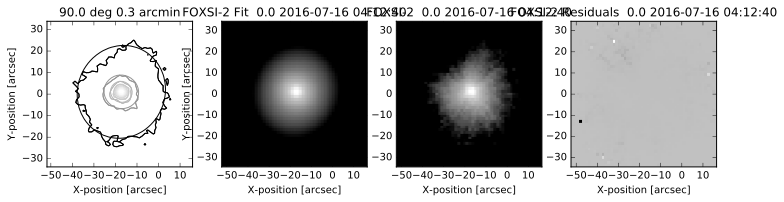

In [96]:
c.plot_all()

In [74]:
polar_angles

<Quantity [   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
              0.,   0.,   0.,   0.,   0.,   0.,   0.,  45.,  45.,  45.,
             45.,  45.,  45.,  45.,  45.,  45.,  45.,  45.,  45.,  45.,
             45.,  45.,  45.,  45.,  90.,  90.,  90.,  90.,  90.,  90.,
             90.,  90.,  90.,  90.,  90.,  90.,  90.,  90.,  90.,  90.,
             90., 135., 135., 135., 135., 135., 135., 135., 135., 135.,
            135., 135., 135., 135., 135., 135., 135., 135.] deg>

In [75]:
offaxis_angles

<Quantity [ 0. , 0.5, 1. , 1.5, 2. , 3. , 5. , 7. , 9. ,-0.5,-1. ,-1.5,
           -2. ,-3. ,-5. ,-7. ,-9. , 0. , 0.5, 1. , 1.5, 2. , 3. , 5. ,
            7. , 9. ,-0.5,-1. ,-1.5,-2. ,-3. ,-5. ,-7. ,-9. , 0. , 0.5,
            1. , 1.5, 2. , 3. , 5. , 7. , 9. ,-0.5,-1. ,-1.5,-2. ,-3. ,
           -5. ,-7. ,-9. , 0. , 0.5, 1. , 1.5, 2. , 3. , 5. , 7. , 9. ,
           -0.5,-1. ,-1.5,-2. ,-3. ,-5. ,-7. ,-9. ] arcmin>

read all of the data in but do not fit yet

In [76]:
fit_params = []
ccds = []
for im, polar_angle, offaxis_angle in zip(images, polar_angle, offaxis_angle):
    c = FoxsiCCDImage(im, polar_angle, offaxis_angle, fit=False, shift=True)
    ccds.append(c)

plot all of the data

In [77]:
fig = plt.figure(figsize=(8, 8))
for ccd in ccds:
    ccd.plot()

circle_rad = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]) * 60
for rad in circle_rad:
    circle=plt.Circle((0,0),rad, fill=False, color='grey', linestyle='dashed')
    fig.gca().add_artist(circle)
plt.title("Data")
#fov = plt.Rectangle((-3.2 * 160 / 2., -3.2 * 160 / 2.), 3.2 * 160, 3.2 * 160., fill=False)
#fig.gca().add_artist(fov)
#plt.savefig('foxsi2_allpsf_data.pdf')

Fit all of the PSFs

In [97]:
ccds = []
for im, polar_angle, offaxis_angle in zip(images, polar_angles, offaxis_angles):
    c = FoxsiCCDImage(im, polar_angle, offaxis_angle, fit=True, shift=True)
    ccds.append(c)

Plot all of fits

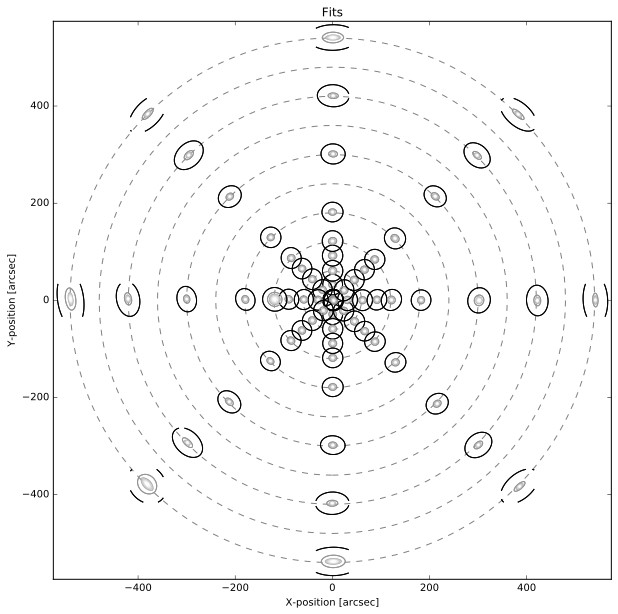

In [98]:
fig = plt.figure(figsize=(10, 10))
for ccd in ccds:
    ccd.plot_fit()

circle_rad = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9]) * 60
for rad in circle_rad:
    circle=plt.Circle((0,0),rad, fill=False, color='grey', linestyle='dashed')
    fig.gca().add_artist(circle)
plt.title('Fits')
#plt.savefig('foxsi2_allpsf_fits.pdf')

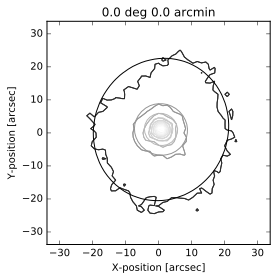

In [99]:
onaxis_ccd = ccds[0]
onaxis_ccd.plot()

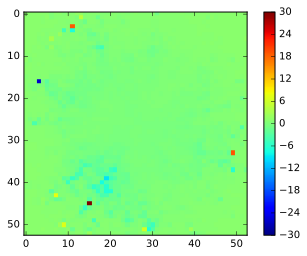

In [100]:
plt.imshow(onaxis_ccd.fit_parameters['fit_residuals'])
plt.clim(-30, 30)
plt.colorbar()

In [101]:
onaxis_ccd.map.data.max()

10012.143

In [102]:
onaxis_ccd.fit_parameters['fit_params']

{'amp1': (7120.3384764477178, 66.873408421202697),
 'amp2': (2431.7111445291389, 50.548479226854546),
 'amp3': (945.53120507404674, 32.990452484025369),
 'center_x': (0.72357566300430443, 0.0087785973923709092),
 'center_y': (1.0403331521830947, 0.008610109090447805),
 'width_x1': (1.4924184990123555, 0.016047774364694005),
 'width_x2': (4.2961367299494055, 0.077769455270037507),
 'width_x3': (9.5083362816536585, 0.12502203282932314),
 'width_y1': (1.4626533823023105, 0.015214541327925898),
 'width_y2': (3.9904808887180137, 0.075938415845968332),
 'width_y3': (10.23249408220955, 0.14998242221439115)}

In [103]:
onaxis_ccd.fit_parameters['popt']

array([  7.12033848e+03,   2.43171114e+03,   9.45531205e+02,
         7.23575663e-01,   1.04033315e+00,   1.49241850e+00,
         4.29613673e+00,   9.50833628e+00,   1.46265338e+00,
         3.99048089e+00,   1.02324941e+01,   4.09114845e-01])

In [146]:
def get_fit_params(kind, error=False):
    if not error:
        x = np.array([c.fit_parameters['fit_params'][kind][0] for c in ccds])
    else:
        x = np.array([c.fit_parameters['fit_params'][kind][1] for c in ccds])
    return x

In [147]:
def reject_outliers(data, m=5):
    return abs(data - np.median(data)) < m * np.std(data)

In [150]:
def plot_fit_gauss_params(kind):
    plt.figure(figsize=(10,10))
    for k in kind:
        x = offaxis_angles.value
        y = get_fit_params(k)
        yerr = get_fit_params(k, error=True)
        good_index = reject_outliers(y) * (yerr < 1000)
        x = x[good_index]
        y = np.abs(y[good_index])
        yerr = yerr[good_index]
        plt.errorbar(x, y, yerr = yerr, label=k, fmt='o')
        parabola = np.polyfit(x, y, 2)
        f = np.poly1d(parabola)
        sort_index = np.argsort(x)
        plt.plot(x[sort_index], f(x[sort_index]), label=k + ' fit')
        plt.title('N = ' + str(len(x)))
    plt.legend()
    plt.show()

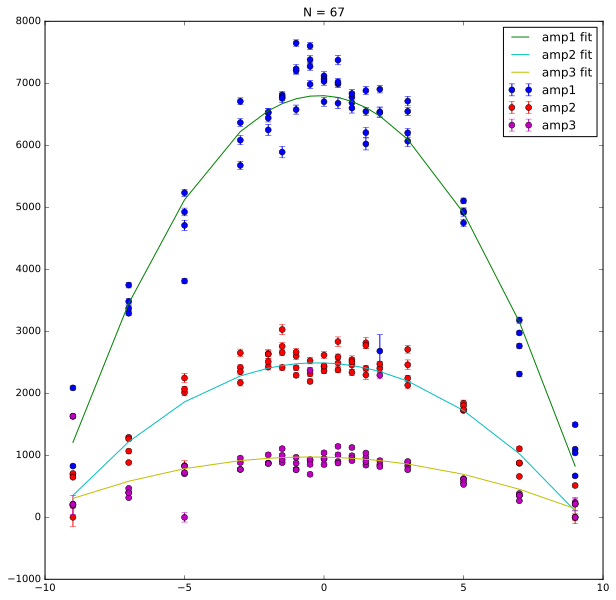

In [151]:
kind = ['amp1', 'amp2', 'amp3']
plot_fit_gauss_params(kind)

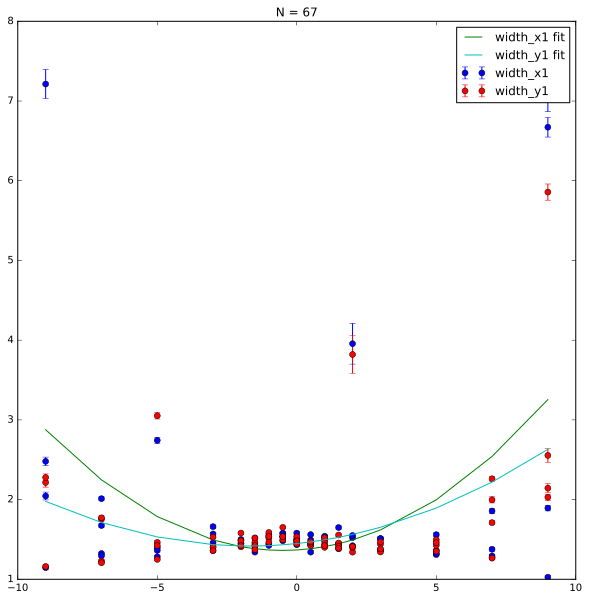

In [152]:
kind = ['width_x1', 'width_y1']
plot_fit_gauss_params(kind)

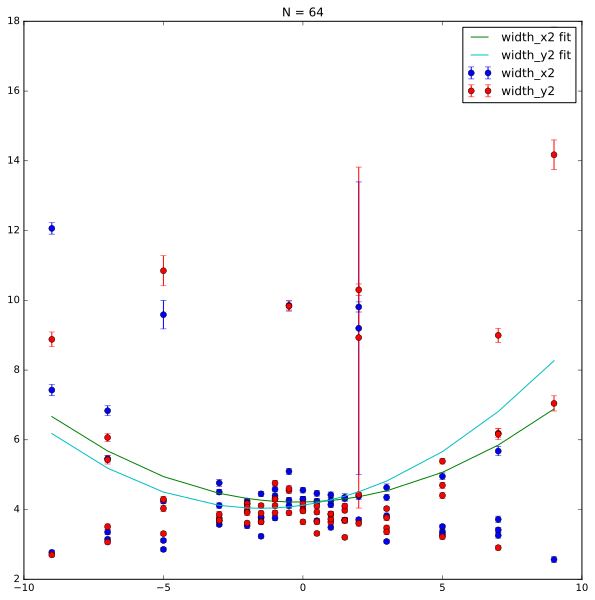

In [153]:
kind = ['width_x2', 'width_y2']
plot_fit_gauss_params(kind)

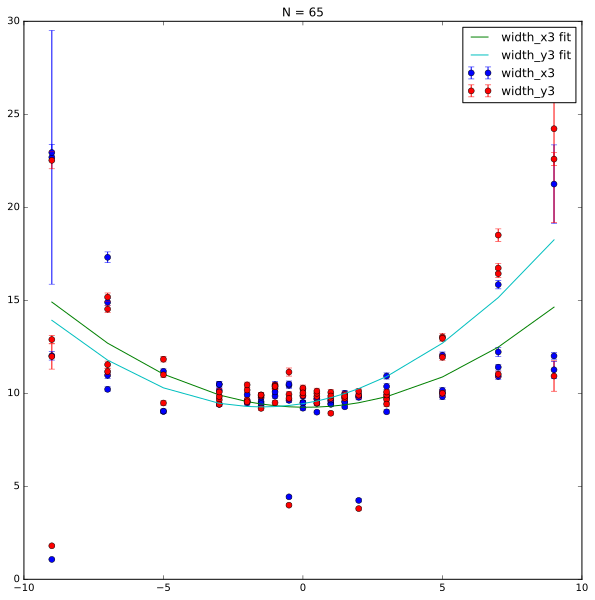

In [154]:
kind = ['width_x3', 'width_y3']
plot_fit_gauss_params(kind)

Do the fits again and store them this time.

In [155]:
gauss_params = []
kind = ['amp1', 'amp2', 'amp3', 'width_x1', 'width_y1', 'width_x2', 'width_y2', 'width_x3', 'width_y3']
for k in kind:
    x = offaxis_angles.value
    y = get_fit_params(k)
    yerr = get_fit_params(k, error=True)
    good_index = reject_outliers(y) * (yerr < 1000)
    x = x[good_index]
    y = y[good_index]
    yerr = yerr[good_index]
    parabola = np.polyfit(x, y, 2)
    gauss_params.append(parabola)

In [156]:
gauss_params

[array([  -71.39454556,   -21.2769735 ,  6800.52436297]),
 array([  -27.91174603,   -13.88588925,  2490.07203878]),
 array([  -9.23938728,   -9.25173996,  970.49253803]),
 array([ 0.01855511,  0.01142189,  1.32399199]),
 array([ 0.01055505,  0.0362494 ,  1.44882029]),
 array([ 0.0315819 ,  0.01212559,  4.21705595]),
 array([ 0.03824057,  0.11604473,  4.12521655]),
 array([ 0.05338144,  0.10609281,  9.20145871]),
 array([ 0.07742323,  0.26391261,  9.48126617])]

In [41]:
np.savetxt('params.txt', gauss_params)

(4909.2758563881125, 1722.8489418575537, 693.24915629722125)
[1.8449792935105616, 5.0672315133335672, 11.066458725060361]
[1.8939435483004827, 5.6614545799282245, 12.736409913006735]
3.14159265359


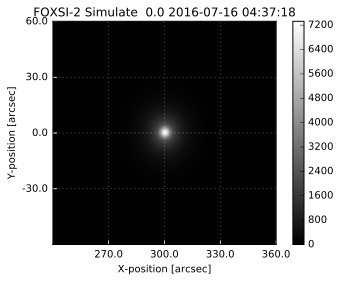

In [163]:
psf(5,0, gauss_params, verbose=True)
psf_map(5,0, gauss_params).plot()
plt.colorbar()

In [164]:
psf(367/60.,0, gauss_params, verbose=True)
psf(144/60.,0, gauss_params, verbose=True)
psf(26/60.,0, gauss_params, verbose=True)
psf(320/60.,0, gauss_params, verbose=True)

(3999.2524452303237, 1360.8574715793079, 568.22388610795838)
[2.0880697090322595, 5.4728172373176989, 11.847585440683529]
[2.0654483364535938, 6.2657414852726756, 13.992214175035464]
3.14159265359
(6338.2270441315877, 2295.9742474698528, 895.06949141057646)
[1.4582819827101028, 4.4280691360880535, 9.7635585493032266]
[1.5966159380233695, 4.6239896215096561, 10.560614217143492]
3.14159265359
(6777.8980320124219, 2478.8136144626101, 964.74849910427054)
[1.3324257131388355, 4.2282407538346813, 9.2574561151335626]
[1.4665103651990992, 4.1826833347888419, 9.6101666562902448]
3.14159265359
(4656.2689860575265, 1622.079853568981, 658.34068679934705)
[1.9126986501618892, 5.1800554924690587, 11.285692392507952]
[1.9423829664931898, 5.8318536918813706, 13.09106079162961]
3.14159265359


<function __main__.<lambda>>

In [43]:
%run /Users/schriste/Desktop/FOXSIpsf/foxsi2_psf.py

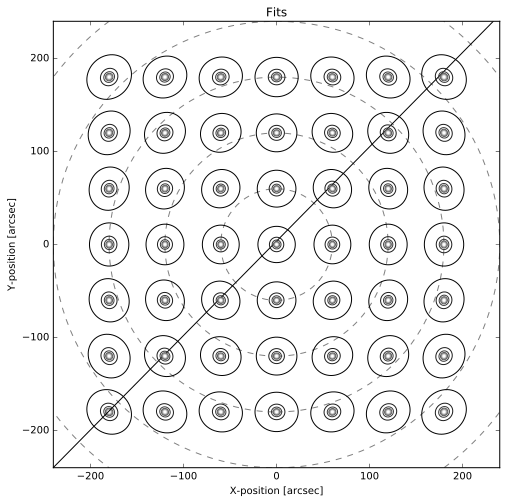

In [44]:
valmax = 3.
step_size = 1.
fig = plt.figure(figsize=(8, 8))
pitch_arr, yaw_arr = (np.arange(-valmax, valmax+step_size, step_size), np.arange(-valmax, valmax+step_size, step_size))
maps = []
for this_pitch in pitch_arr:
    for this_yaw in yaw_arr:
        maps.append(psf_map(this_pitch, this_yaw, gauss_params))

cmap = sunpy.map.Map(maps, composite=True)

for i, m in enumerate(np.arange(0, len(pitch_arr) * len(yaw_arr), 1)):
    cmap.set_levels(i, np.arange(1,100,10), percent=True)

cmap.plot()

circle_rad = np.array([1, 2, 3, 4, 5]) * 60
for rad in circle_rad:
    circle=plt.Circle((0,0),rad, fill=False, color='grey', linestyle='dashed')
    fig.gca().add_artist(circle)
3.2 * 160 / 2.
fov = plt.Rectangle((-3.2 * 160 / 2., -3.2 * 160 / 2.), 3.2 * 160, 3.2 * 160., fill=False)
fig.gca().add_artist(fov)
plt.title('Fits')
plt.savefig('foxsi2_allpsf_model.pdf')

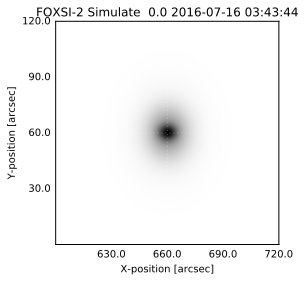

In [45]:
psf_map(10, 0, gauss_params).plot()

In [46]:
psf_map(0, 0, gauss_params)

SunPy GenericMap
---------
Observatory:	 FOXSI-2 Simulate
Instrument:	 
Detector:	 
Measurement:	 0.0
Wavelength:	 0.0
Obs Date:	 2016-07-16 03:43:44
dt:		 0.000000 s
Dimension:	 [ 1200.  1200.] pix
scale:		 [ 0.1  0.1] arcsec / pix

array([[  1.14258050e-15,   1.22137669e-15,   1.30546170e-15, ...,
          1.39518028e-15,   1.30546170e-15,   1.22137669e-15],
       [  1.22641618e-15,   1.31099396e-15,   1.40124862e-15, ...,
          1.49755021e-15,   1.40124862e-15,   1.31099396e-15],
       [  1.31624775e-15,   1.40702061e-15,   1.50388617e-15, ...,
          1.60724159e-15,   1.50388617e-15,   1.40702061e-15],
       ..., 
       [  1.41249238e-15,   1.50990260e-15,   1.61385102e-15, ...,
          1.72476383e-15,   1.61385102e-15,   1.50990260e-15],
       [  1.31624775e-15,   1.40702061e-15,   1.50388617e-15, ...,
          1.60724159e-15,   1.50388617e-15,   1.40702061e-15],
       [  1.22641618e-15,   1.31099396e-15,   1.40124862e-15, ...,
          1.49755021e-15,   1.401248

In [47]:
from astropy.convolution import convolve, convolve_fft
import os

In [48]:
class Psf(object):
    """The Point Spread Function
    """
    def __init__(self, pitch, yaw):
        # load the PSF parameters
        #path = os.path.dirname(pyfoxsi.__file__)
        #for i in np.arange(3):
        #    path = os.path.dirname(path)
        #path = os.path.join(path, 'data/')
        path = '/Users/schriste/Developer/repositories/foxsi-smex/data'
        params = np.loadtxt(os.path.join(path, 'psf_parameters.txt'))

        # need to use negative offaxis angles. currently only uses positive.
        # currently assumes it is symmetric.
        self.offaxis_angle, self.polar_angle = self._calculate_angles(pitch, yaw)
        poly_params = []
        for g in params:
            f = np.poly1d(g)
            poly_params.append(f(self.offaxis_angle))

        amplitude = (poly_params[0], poly_params[1], poly_params[2])
        width_x = [poly_params[3], poly_params[5], poly_params[7]]
        width_y = [poly_params[4], poly_params[6], poly_params[8]]
        self.func = lambda (x, y): multi_gauss2d((x, y), amplitude, (0, 0), width_x, width_y, self.polar_angle)
        self.data = self._calculate_data()
        self.fwhm = self._calculate_fwhm()
        self.map = self._create_map()

    def _calculate_angles(self, pitch, yaw):
        """Calculate the polar angle and offaxis angle"""
        offaxis_angle = np.sqrt(pitch ** 2 + yaw ** 2)
        polar_angle = np.arctan2(yaw, pitch)
        return (offaxis_angle, polar_angle)

    def _calculate_parameter(self, offaxis_angle, params):
        f = np.poly1d(params)
        return f(offaxis_angle)

    def _calculate_data(self, scale=0.1, extent=(-20,20)):
        x, y = np.meshgrid(np.arange(extent[0], extent[1], scale), np.arange(extent[0], extent[1], scale))
        im = self.func((x,y)).reshape(x.shape)
        return im
        
    def _create_map(self, scale=0.1, extent=(-20,20)):
        iy, ix = np.unravel_index(np.argmax(self.data), self.data.shape)
        header =  {'cdelt1': scale,
                   'cdelt2': scale,
                   'telescop': 'FOXSI-2 Simulate',
                   'crpix1': iy, 'crpix2': ix,
                   'crval1': 0, 'crval2': 0}
        this_map = sunpy.map.Map(self.data, header)
        return this_map

    def plot(self):
        fig = plt.figure()
        ax = plt.subplot()
        self.map.plot()
        scale = 0.1
        extent = (-20,20)
        x, y = np.meshgrid(np.arange(extent[0], extent[1], scale), np.arange(extent[0], extent[1], scale))
        
    def _calculate_fwhm(self):
        """Calculate the fwhm"""
        scale = 0.1
        extent = (-20,20)
        x, y = np.meshgrid(np.arange(extent[0], extent[1], scale), np.arange(extent[0], extent[1], scale))
        cs = plt.contour(x, y, self.data, [self.data.max() * 0.5])
        # so that the plot does not show up
        plt.close()
        p = cs.collections[0].get_paths()
        r_fwhm = 2 * np.sqrt(p[0].vertices[:, 0] ** 2 + p[0].vertices[:, 1] ** 2)
        return r_fwhm.max(), r_fwhm.min()

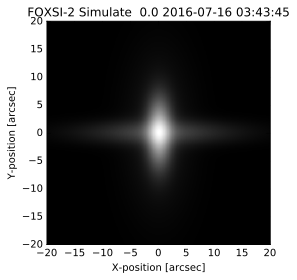

In [49]:
p = Psf(6 * u.arcmin, 0 * u.arcmin).plot()

In [50]:
valmax = 8.
step_size = 1.
fig = plt.figure(figsize=(10, 10))
pitch_arr = np.arange(-valmax, valmax+step_size, step_size)

fwhm = []
for this_pitch in pitch_arr:
    fwhm.append(Psf(this_pitch * u.arcmin, 0 * u.arcmin).fwhm)
fwhm = np.array(fwhm)

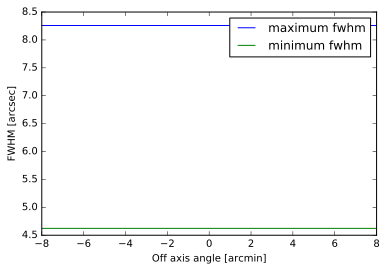

In [51]:
plt.plot(pitch_arr, fwhm[:,0], label='maximum fwhm')
plt.plot(pitch_arr, fwhm[:,1], label='minimum fwhm')
plt.xlabel('Off axis angle [arcmin]')
plt.ylabel('FWHM [arcsec]')
plt.legend()

In [52]:
import numpy as np
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
gauss = Gaussian2D(1, 0, 0, 3, 3)
# Fake image data including noise
x = np.arange(-100, 101)
y = np.arange(-100, 101)
x, y = np.meshgrid(x, y)
data_2D = gauss(x, y) + 0.1 * (np.random.rand(201, 201) - 0.5)

In [53]:
gauss_kernel = Gaussian2DKernel(2)
smoothed_data_gauss = convolve(data_2D, gauss_kernel)

In [54]:
tophat_kernel = Tophat2DKernel(5)
smoothed_data_tophat = convolve(data_2D, tophat_kernel)

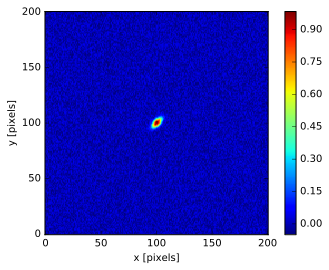

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
gauss = Gaussian2D(1, 0, 0, 4, 2, np.pi/4.)
# Fake image data including noise
x = np.arange(-100, 101)
y = np.arange(-100, 101)
x, y = np.meshgrid(x, y)
data_2D = gauss(x, y) + 0.1 * (np.random.rand(201, 201) - 0.5)
plt.imshow(data_2D, origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

In [56]:
f = '/Users/schriste/Google Drive/Work/FOXSI SMEX/Data/hsi_image_20050513_164526to164626_pixon_3arcsecx64_25to50kev_d1to9.fits'

In [57]:
from sunpy.map import Map
import numpy as np

In [58]:
hsi = Map(f)

In [59]:
hsi
hsi.plot_settings['contours'] = np.arange(1,100)

AttributeError: Unknown property contours

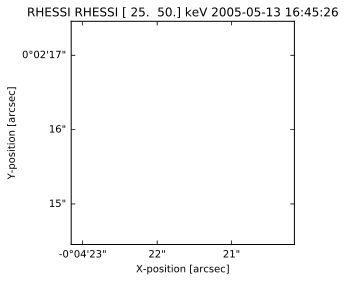

In [60]:
hsi.plot()

In [ ]:
from pyfoxsi.psf import convolve, psf
from astropy.convolution import Gaussian2DKernel
import astropy.units as u

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
fhsi = convolve(hsi)

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2)
hsi.plot(axes=ax1)
fhsi.plot(axes=ax2)
f.subplots_adjust(right=1.8)
plt.savefig('rhessi_foxsi_compare.pdf')

In [ ]:
hsi.plot()
plt.colorbar()

In [ ]:
fhsi.plot()
plt.colorbar()

In [ ]:
Gaussian2DKernel(10,x_size=None).array.shape

In [ ]:
this_psf = psf(0 * u.arcmin, 0 * u.arcmin, scale=hsi.scale.x, oversample=3, size=100)


In [ ]:
this_psf.array.shape

In [ ]:
plt.imshow(this_psf)

In [ ]:
i = 0
factor = 0.3
while(i < 10):
    this_max_index = np.argmax(fhsi.data)
    psf()